In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import csv
import re
news_reddit = pd.read_csv('../data/news_lang.csv', sep=';').drop('Unnamed: 0', axis=1)

In [2]:
ones = news_reddit[news_reddit['score']==1].sample(n=(news_reddit[news_reddit['score']>1].shape[0]-news_reddit[news_reddit['score']==0].shape[0]))
zeros = news_reddit[news_reddit['score']==0]
rest = news_reddit[news_reddit['score']>1]

news_reddit = pd.concat([ones, zeros, rest])
news_reddit.sample(frac=1)
news_reddit.head()

,title,score,num_comments,created_utc,lang
554026,Australian Police Arrest 4 Men Allegedly Plott...,1,0,1501425378,en
552468,Kapolda Metro Jaya Apresiasi Aksi 287 Berlangs...,1,0,1501298041,id
172185,AMAZING! The Media Does Not Want You To See Wh...,1,0,1490068207,en
584121,Những Điều Cần Biết Khi Khởi Nghiệp Kinh Doanh...,1,0,1503043888,vi
285688,OK Google! Plenty of Useful Things You Can Say...,1,0,1495866597,en


In [3]:
news_reddit = news_reddit[news_reddit['lang'] == 'en']
news_reddit["title"] = news_reddit['title'].apply(lambda x:  re.sub(r"\'.+?", '', x))
pattern = r'[\d.,]+|[A-Z][.A-Z]+\b\.*|\w+|\S'
tokenizer = RegexpTokenizer(pattern)
news_reddit["tokenized_titles"] = news_reddit['title'].apply(lambda x: tokenizer.tokenize(x.lower()))

In [4]:
def load_fb_embeddings(dict_dir, max_dict_lenght):
    dict_df = pd.read_csv(dict_dir, sep=';', nrows=max_dict_lenght, skiprows=1, encoding='utf8', quoting=csv.QUOTE_NONE,
                          header=None)
    embeddings_word_index = dict_df.iloc[:, 0]
    embeddings_word_index = pd.Series(embeddings_word_index.index, index=embeddings_word_index)
    embeddings_word_index = embeddings_word_index.to_dict()
    # throw out the first column (with words) and last one (with nans)
    embeddings_matrix = np.array(dict_df.iloc[:, 1:-1])
    return embeddings_word_index, embeddings_matrix

def get_text_embs(word_list, emb_index, emb_matrix):
    return np.mean([emb_matrix[emb_index.get(word, 0)] for word in word_list], axis=0)

In [5]:
embeddings_word_index, embedding_matrix = load_fb_embeddings('../data/wiki10k.csv', None)

In [6]:
pca = PCA(n_components=30)
pca_emb = pca.fit_transform(embedding_matrix)
tsne = TSNE(n_components=2, random_state=0, verbose=1, n_iter=1000)
reduced_emb = tsne.fit_transform(pca_emb)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.019s...
[t-SNE] Computed neighbors for 10000 samples in 6.019s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.564258
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.625145
[t-SNE] Error after 251 iterations: 1797693134862315708145274237317043567980705

In [7]:
print(get_text_embs(news_reddit["tokenized_titles"][0], embeddings_word_index, embedding_matrix).shape)
get_text_embs(news_reddit["tokenized_titles"][0], embeddings_word_index, embedding_matrix)[0:10]

(300,)


array([ 0.10169276, -0.06427216, -0.11815847,  0.1615283 , -0.1071124 ,
        0.0319062 , -0.04408632, -0.18752063, -0.04514017,  0.1163215 ])

In [8]:
X = np.vstack(news_reddit["tokenized_titles"].apply(get_text_embs, args=(embeddings_word_index, embedding_matrix)))
Y = np.array([1 if x > 1 else 0 for x in news_reddit.score])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

In [9]:
clf = LogisticRegression()
clf.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [10]:
accuracy_score(Y_test, clf.predict(X_test))

0.7489095090808153

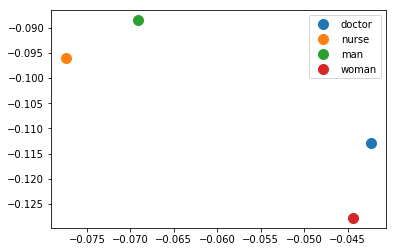

In [20]:
import matplotlib.pyplot as plt
reduced_emb[embeddings_word_index['king']]

fig, ax = plt.subplots()
ax.margins(0.05)
for name in ['doctor', 'nurse', 'man', 'woman']:
    ax.plot(reduced_emb[embeddings_word_index[name]][0], reduced_emb[embeddings_word_index[name]][1], marker='o', linestyle='', ms=10, label=name)
ax.legend()
plt.show()